In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [12]:
!pip install groq

In [ ]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import copy
import re
import openpyxl
import seaborn as sns
import seaborn.objects as so
from groq import Groq
os.environ["GROQ_API_KEY"] = "???"

In [22]:
class Astar_LLM_ImgData():
    def __init__(self, path, start, goal, env_discription, map_range, max_margin, map_sheet='Sheet1', dis_table_sheet='Sheet2') -> None:
        from groq import Groq
        self.file_path = path
        self.map_sheet = map_sheet
        self.dis_table_sheet = dis_table_sheet
        self.map_range = map_range
        self.max_margin = max_margin
        self.map = None
        self.dis_table = None
        self.result_demo = np.ones((self.max_margin, self.max_margin, 3))
        self.action_space = {
            0: [-1, 0],
            1: [1, 0],
            2: [0, 1],
            3: [0, -1],
            4: [-1, 1],
            5: [-1, -1],
            6: [1, 1],
            7: [1, -1]
        }

        self.start_node = start
        self.target_node = goal
        self.cur_node = self.start_node
        self.env_discription = env_discription
        self.pre_node = None

        self.step = 0
        self.min_step = 0
        self.min_dis = 1024
        self.min_node = None

        self.open_queue = {}
        self.close_queue = {str(self.start_node): self.start_node}
        self.par_nodes = {}

        self.model_name = "llama3-8b-8192"
        self.api_key = os.environ.get("GROQ_API_KEY")
        self.client = Groq(api_key=self.api_key)

        self.ini_massages = None
        self.suggested_points = []  # dùng để lưu lại điểm đề xuất mỗi bước
        self.visited = set()  # 🔧 ADDED: để theo dõi các node đã xét
        self.path = []

    def generate_map(self):
      wb = openpyxl.load_workbook(self.file_path)
      ws = wb[self.map_sheet]
      _range = self.map_range
      map = []
      for row in ws[_range]:
        map_row = []
        for cell in row:
          map_row.append(cell.value)
        map.append(map_row)
      map = np.array(map) # shape: [32, 32] or [16, 16]
      self.map = map

      self.obs = [(i, j) for i in range(map.shape[0])
                         for j in range(map.shape[1])
                         if map[i][j] == 0]

    def generate_dis_table(self):
      wb = openpyxl.load_workbook(self.file_path)
      ws = wb[self.dis_table_sheet]
      _range = self.map_range
      dis_table = []
      for row in ws[_range]:
        dis_table_row = []
        for cell in row:
          dis_table_row.append(cell.value)
        dis_table.append(dis_table_row)
      dis_table = np.array(dis_table) # shape: [32, 32] or [16, 16]
      self.dis_table = dis_table


    def message_initialize(self):
      client = self.client
      messages = [{'role': 'system', 'content': 'You are a good assistant! Man!'}, ]

      # tell the basic information of the map
      grid_world_inf = "We have a " + str(self.max_margin) + "*" + str(self.max_margin) + " grid map in which there are totally " + str(int(self.max_margin * self.max_margin)) + " grids inside. In this map, we use [i, j] to represent the grid of ith row and jth column. Additionally, there is a binary number which is '1' or '0' in each grid to represent the obstacle conditions that '1' means the grid is free whilst '0' means the grid has been occupied by an obstacle and the agent cannot move to it. Our objective is to make an agent at the starting node to bypass obstacles and reach the designated target node. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. Here is the detail information below. "
      print("User: ", grid_world_inf)
      messages.append({'role': 'user', 'content': grid_world_inf}, )

      # Sử dụng client.chat.completions.create thay vì openai.ChatCompletion.create
      chat_for_task = client.chat.completions.create(
          model=self.model_name,  # Cần đảm bảo model_name tương thích với Groq
          messages=messages
      )
      reply_for_task = chat_for_task.choices[0].message.content
      print(f"Groq: {reply_for_task}")  # Thay ChatGPT thành Groq
      messages.append({'role': 'assistant', 'content': reply_for_task})

      # tell the start_node and target_node:
      start_and_target = "Start node: " + str(self.start_node) + "; Target node: " + str(self.target_node) + " which is at the agent's lowerleft direction. "
      print("User: ", start_and_target)
      messages.append({'role': 'user', 'content': start_and_target}, )
      chat_for_task = client.chat.completions.create(
          model=self.model_name,
          messages=messages
      )
      reply_for_task = chat_for_task.choices[0].message.content
      print(f"Groq: {reply_for_task}")
      messages.append({'role': 'assistant', 'content': reply_for_task})

      # tell the obstacle information.
      obstacles_inf = self.env_discription
      print("User: ", obstacles_inf)
      messages.append({'role': 'user', 'content': obstacles_inf}, )
      chat_for_task = client.chat.completions.create(
          model=self.model_name,
          messages=messages
      )
      reply_for_task = chat_for_task.choices[0].message.content
      print(f"Groq: {reply_for_task}")
      messages.append({'role': 'assistant', 'content': reply_for_task})

      # tell the agent action space and distance standard
      action_inf = "Agent action space (set current coordinate of the agent is [i, j]): Action 0: move up ([i, j] -> [i-1, j]); Action 1: move down ([i, j] -> [i+1, j]); Action 2: move right ([i, j] -> [i, j+1]); Action 3: move left ([i, j] -> [i, j-1]); Action 4: move upper right [i, j] -> [i-1, j+1] Action 5: move upper left ([i, j] -> [i-1, j-1]); Action 6: move lower right ([i, j] -> [i+1, j+1]); Action 7: move lower left ([i, j] -> [i+1, j-1]). Notice: 1. In this map, row index i increases from upward direction to downward direction, whilst column index j increases from leftward direction to righward direction. 2. When the agent is located in a grid adjacent to an obstacle, some actions in the action space will not be achieved. Please dynamically adjust the agent's actions at runtime. Distance standard: Euclidean distance. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
      print("User: ", action_inf)
      messages.append({'role': 'user', 'content': action_inf}, )
      chat_for_task = client.chat.completions.create(
          model=self.model_name,
          messages=messages
      )
      reply_for_task = chat_for_task.choices[0].message.content
      print(f"Groq: {reply_for_task}")
      messages.append({'role': 'assistant', 'content': reply_for_task})

      # tell the objective
      obj_inf = "Our objective is to move the agent step by step with the actions above bypassing the obstacles from the start node to the target node. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
      print("User: ", obj_inf)
      messages.append({'role': 'user', 'content': obj_inf}, )
      chat_for_task = client.chat.completions.create(
          model=self.model_name,
          messages=messages
      )
      reply_for_task = chat_for_task.choices[0].message.content
      print(f"Groq: {reply_for_task}")
      messages.append({'role': 'assistant', 'content': reply_for_task})

      self.ini_massages = copy.deepcopy(messages)

    def extract_node(self, reply):
      """
      This method is to extract the nodes of the search space in each step molocation. Commonly, there are multi-numbers
      of coordinate tuples in the context. Therefore, it is fairly different from extract_node() function.
      """
      context = reply
      pattern = r'\[[\d,\s]+\]'
      try:
        lists = re.findall(pattern, context)
        search_nodes = [eval(lst) for lst in lists]
      except IndexError:
        print('Empty list. It is caused by error output of LLM.')
      finally:
        if len(search_nodes) == 0:
          return search_nodes
        else:
          return search_nodes[-1]

    def _manhattan_g(self, node):
      return abs(node[0] - self.start_node[0]) + abs(node[1] - self.start_node[1])


    def opt_node_select(self, opt_actions):
        """
        Select the optimal next node from a list of proposed actions using A* strategy.
        g(n): calculated as Manhattan distance from start_node, only if path is valid (no obstacles).
        h(n): estimated cost to goal from dis_table (converted from negative to positive).
        """
        if sum(i > 7 for i in opt_actions) != 0 or sum(i < 0 for i in opt_actions) != 0 or \
                len(opt_actions) != len(set(opt_actions)) or len(opt_actions) == 0:
            return

        for act in opt_actions:
            dx, dy = self.action_space[act]
            sup_x, sup_y = self.cur_node[0] + dx, self.cur_node[1] + dy
            sup_node = [sup_x, sup_y]

            if not (0 <= sup_x < self.max_margin and 0 <= sup_y < self.max_margin):
                continue
            if self.map[sup_x][sup_y] == 0 or abs(self.dis_table[sup_x][sup_y]) == 1024:
                continue
            if tuple(sup_node) in self.visited or str(sup_node) in self.close_queue:
                continue

            if sup_node in self.open_queue.values():
                par_key = list(self.open_queue.keys())[list(self.open_queue.values()).index(sup_node)]
                par = self.par_nodes[par_key]
                if self._manhattan_g(self.cur_node) < self._manhattan_g(par):
                    self.par_nodes[par_key] = self.cur_node
            else:
                end = 0 if len(self.open_queue) == 0 else list(self.open_queue.keys())[-1] + 1
                self.open_queue[end] = sup_node
                self.par_nodes[end] = self.cur_node

        if not self.open_queue:
            print("Warning: open_queue is empty, no valid nodes available.")
            return

        def f_cost(node):
            g = self._manhattan_g(node)
            h = -self.dis_table[node[0]][node[1]]
            return g + h

        opt_key = min(self.open_queue, key=lambda i: f_cost(self.open_queue[i]))
        print(f'opt_key: {opt_key}')

        to_close = self.open_queue.pop(opt_key)
        to_close_par = self.par_nodes.pop(opt_key)

        self.close_queue[str(to_close)] = to_close_par
        self.pre_node = to_close_par
        self.cur_node = to_close
        self.visited.add(tuple(to_close))





    def visualize_step(self, opt_actions, selected_node=None):
        # Khởi tạo nền trắng
        grid = np.ones((self.max_margin, self.max_margin, 3), dtype=np.uint8) * 255

        # Chướng ngại vật: màu đen
        for i, j in self.obs:
            grid[i, j] = [0, 0, 0]

        # Điểm đã xét qua (visited): màu xanh lá cây
        for i, j in self.visited:
            grid[i, j] = [0, 255, 0]

        # Đường đi tối ưu: màu cam
        for i, j in self.path:
            grid[i, j] = [255, 165, 0]

        ci, cj = self.cur_node

        # Điểm được đề xuất: màu vàng
        for act in opt_actions:
            if act not in self.action_space:
                continue
            ni = ci + self.action_space[act][0]
            nj = cj + self.action_space[act][1]
            if (
                0 <= ni < self.max_margin
                and 0 <= nj < self.max_margin
                and (ni, nj) not in self.visited
                and (ni, nj) != self.cur_node
                and (ni, nj) not in self.path
            ):
                grid[ni, nj] = [255, 255, 0]  # vàng

        # Điểm đang được chọn để đi tiếp: màu đỏ
        if selected_node is not None:
            si, sj = selected_node
            grid[si, sj] = [255, 0, 0]
        else:
            # Nếu chưa có node chọn, tô node hiện tại
            grid[ci, cj] = [255, 0, 0]

        # Start & Goal: xanh dương
        si, sj = self.start_node
        gi, gj = self.target_node
        grid[si, sj] = [0, 0, 255]
        grid[gi, gj] = [0, 0, 255]

        # Hiển thị (nếu cần)
        plt.imshow(grid)
        plt.title("A* Visualization")
        plt.axis('off')
        plt.show()



In [ ]:
map_name = 'Aisle'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 30]
goal = [29, 2]
map_range = 'A1:AF32'
max_margin = 32
env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:22], j: [13:18]; Region B: i: [26:31], j: [13:18]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Canyon'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [3, 23]
goal = [21, 1]
map_range = 'A1:AF32'
max_margin = 32
env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:15], j: [0:21]; Region B: i: [0:15], j: [25:31]; C: i: [22:31], j: [0:6]; Region D: i: [22:31], j: [10:31]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Double_door'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 29]
goal = [28, 1]
map_range = 'A1:AF32'
max_margin = 32
env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:26], j: [0:10]; Region B: i: [0:20], j: [11:21]; Region C: i: [30:31], j: [10:21]; Region D: i: [23:31], j: [21:31] except the grid i=23 and j=21. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "

env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Aisle_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 22]
goal = [21, 2]
map_range = 'A1:X24'
max_margin = 24
env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:15], j: [9:13]; Region B: i: [19:23], j: [9:13]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Canyon_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [2, 17]
goal = [15, 2]
map_range = 'A1:X24'
max_margin = 24
env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:11], j: [0:15]; Region B: i: [0:11], j: [19:23]; C: i: [16:23], j: [0:4]; Region D: i: [16:23], j: [8:23]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Double_door_24'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 22]
goal = [19, 1]
map_range = 'A1:X24'
max_margin = 24
env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:17], j: [0:7]; Region B: i: [0:15], j: [8:16]; Region C: i: [21:23], j: [7:15]; Region D: i: [18:23], j: [16:23] except the region where i=18 and j=16. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [23]:
map_name = 'Aisle_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 13]
#goal = [14, 1]
goal = [14, 1]
env_discription = "Obstacles: This map mainly includes two obstacles respectively located at region A and B. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:8], j: [7:9]; Region B: i: [12:15], j: [7:9]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
map_range ='A1:P16'
max_margin = 16
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Canyon_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [2, 10]
goal = [11, 1]
env_discription = "Obstacles: This map mainly includes four obstacles respectively located at region A, B, C and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:8], j: [0:9]; Region B: i: [0:8], j: [12:15]; C: i: [12:15], j: [0:3]; Region D: i: [12:15], j: [6:15]. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
map_range ='A1:P16'
max_margin = 16
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [ ]:
map_name = 'Double_door_16'
path = '/content/gdrive/MyDrive/LLM_Astar/maps/' + map_name + '.xlsx'
start = [1, 15]
goal = [14, 1]
env_discription = "Obstacles: This map includes four obstacles respectively located at region A, B, C, and D. This is the detail decription of grid regions occupied by obstacles, we deployed i and j as the index of row and column: Region A: i: [0:12], j: [0:4]; Region B: i: [0:10], j: [5:10]; Region C: i=15, j: [5:9]; Region D: i: [13:15], j: [10:15] except the grid i=13 and j=10. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. "
map_range ='A1:P16'
max_margin = 16
env = Astar_LLM_ImgData(path, start, goal, env_discription, map_range, max_margin)

In [24]:
env.generate_map()
env.generate_dis_table()
env.generate_dis_table()

User:  We have a 16*16 grid map in which there are totally 256 grids inside. In this map, we use [i, j] to represent the grid of ith row and jth column. Additionally, there is a binary number which is '1' or '0' in each grid to represent the obstacle conditions that '1' means the grid is free whilst '0' means the grid has been occupied by an obstacle and the agent cannot move to it. Our objective is to make an agent at the starting node to bypass obstacles and reach the designated target node. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt. Here is the detail information below. 
Groq: I've noted the following information:

* You have a 16x16 grid map with 256 total grids, represented by [i, j] coordinates.
* Each grid contains a binary value (0 or 1) indicating obstacle condition:
	+ 1: free grid (agent can move)
	+ 0: occupied grid (obstacle, agen

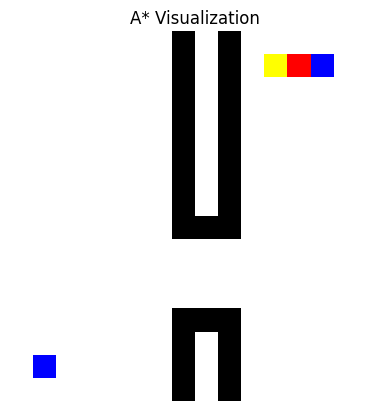

User:  Now, the agent has moved from [1, 13] to [1, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

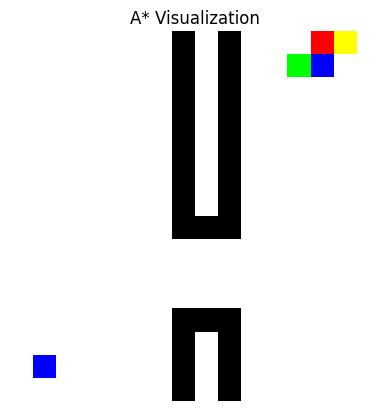

User:  Now, the agent has moved from [1, 12] to [0, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

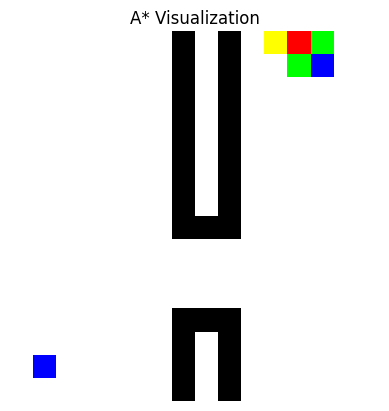

User:  Now, the agent has moved from [0, 13] to [0, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

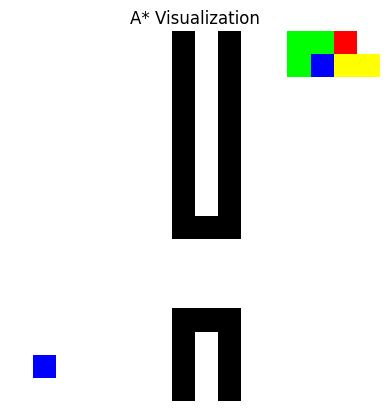

User:  Now, the agent has moved from [0, 13] to [0, 14] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

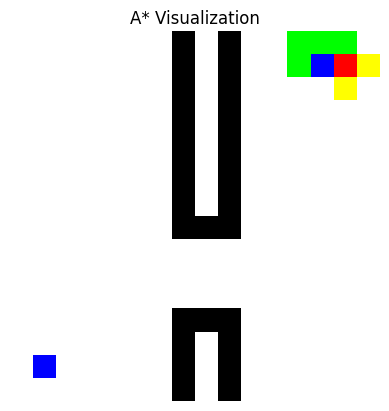

User:  Now, the agent has moved from [0, 14] to [1, 14] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

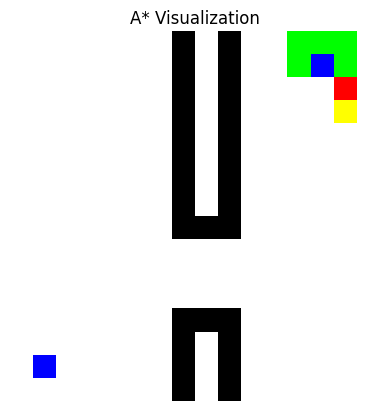

User:  Now, the agent has moved from [1, 14] to [2, 14] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

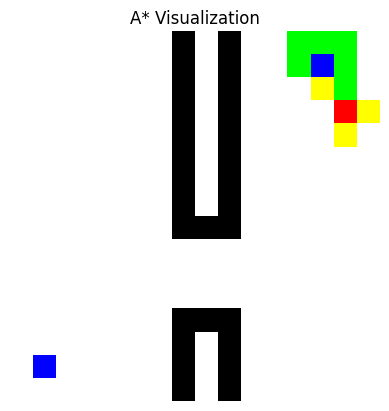

User:  Now, the agent has moved from [2, 14] to [3, 14] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

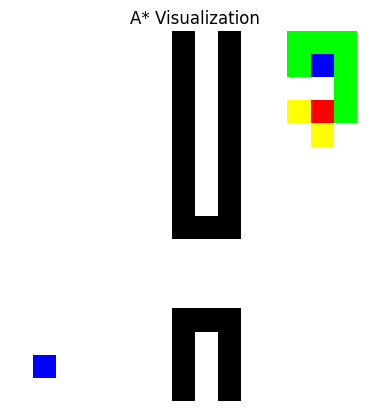

User:  Now, the agent has moved from [3, 14] to [3, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

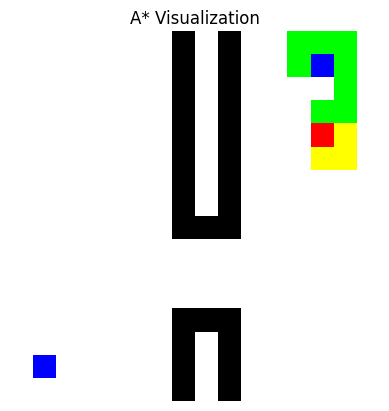

User:  Now, the agent has moved from [3, 13] to [4, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

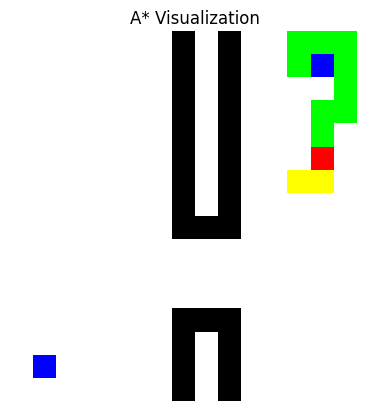

User:  Now, the agent has moved from [4, 13] to [5, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

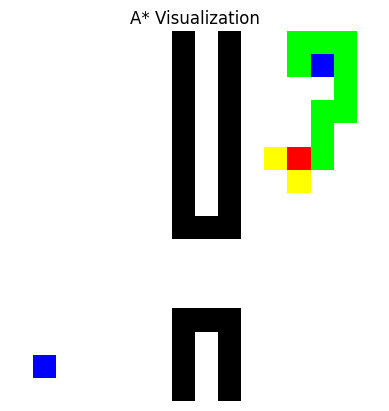

User:  Now, the agent has moved from [4, 13] to [5, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

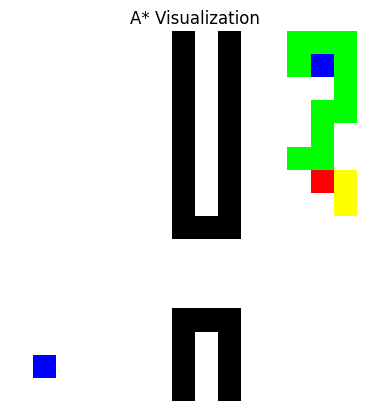

User:  Now, the agent has moved from [5, 13] to [6, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

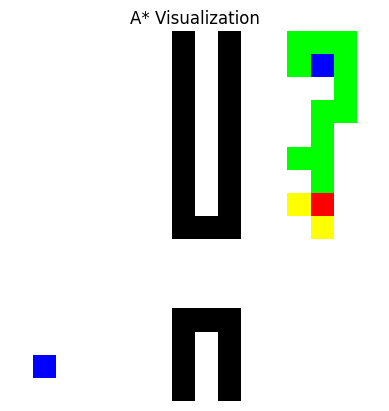

User:  Now, the agent has moved from [6, 13] to [7, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

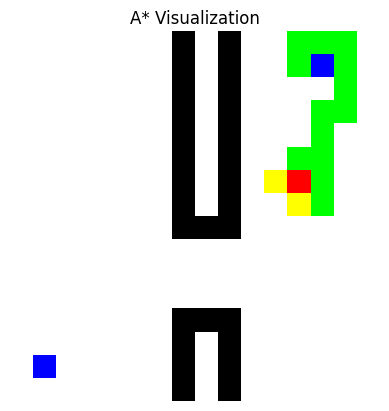

User:  Now, the agent has moved from [6, 13] to [6, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

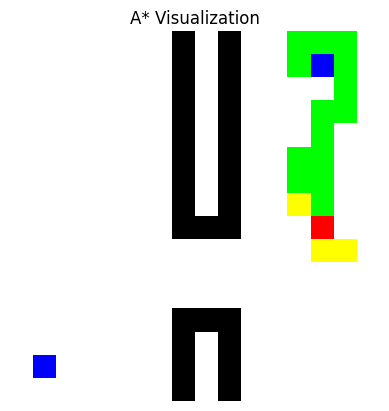

User:  Now, the agent has moved from [7, 13] to [8, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

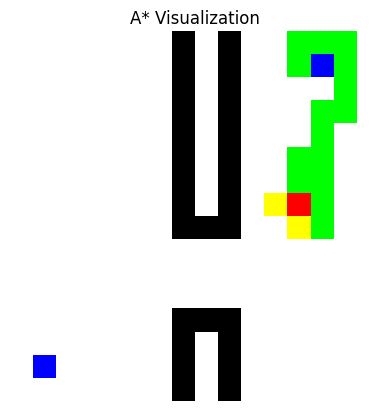

User:  Now, the agent has moved from [7, 13] to [7, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

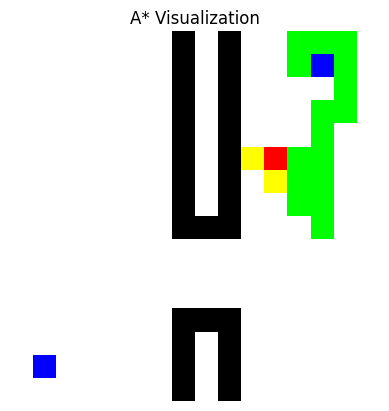

User:  Now, the agent has moved from [6, 12] to [5, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

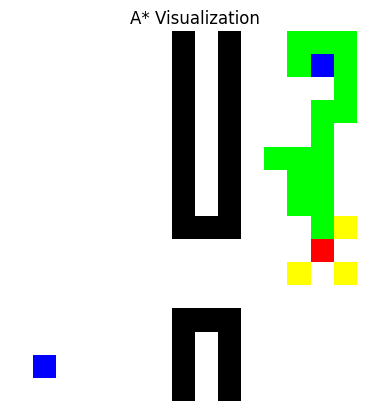

User:  Now, the agent has moved from [8, 13] to [9, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

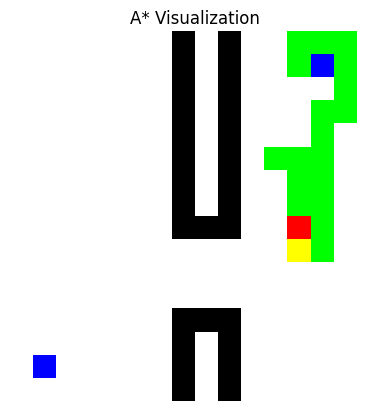

User:  Now, the agent has moved from [8, 13] to [8, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

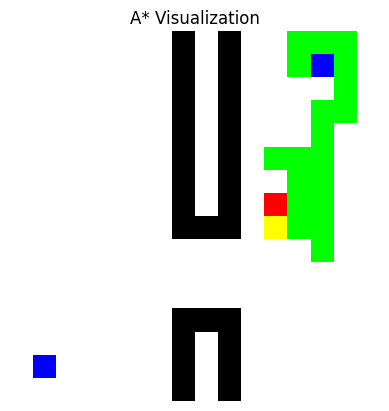

User:  Now, the agent has moved from [7, 12] to [7, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

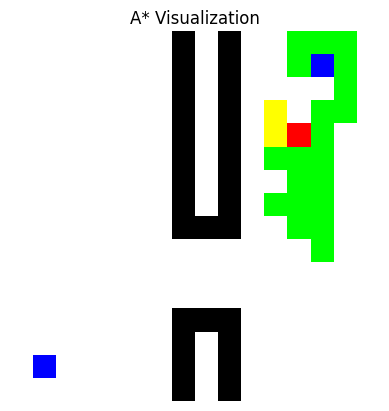

User:  Now, the agent has moved from [5, 11] to [4, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

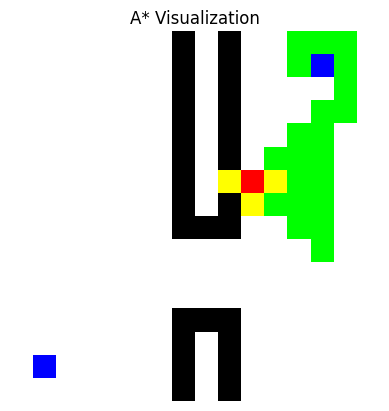

User:  Now, the agent has moved from [5, 11] to [6, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

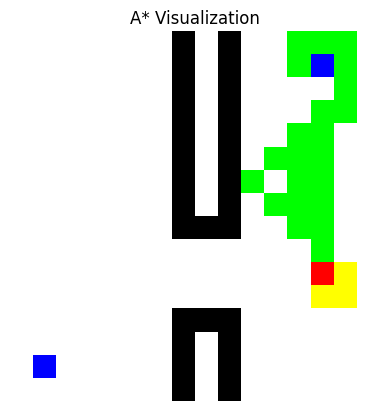

User:  Now, the agent has moved from [9, 13] to [10, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. C

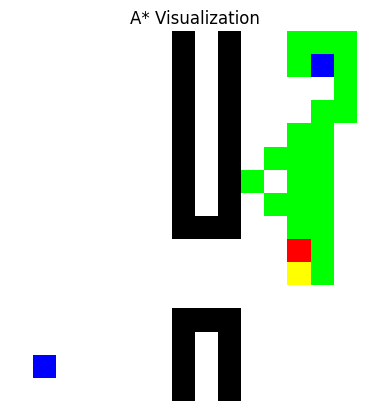

User:  Now, the agent has moved from [8, 12] to [9, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

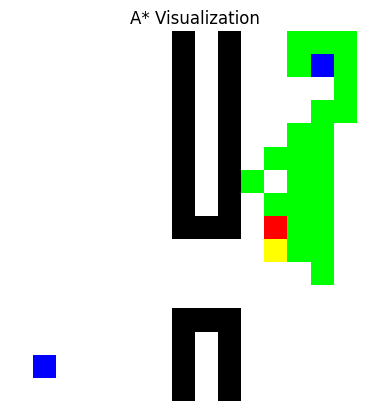

User:  Now, the agent has moved from [7, 11] to [8, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

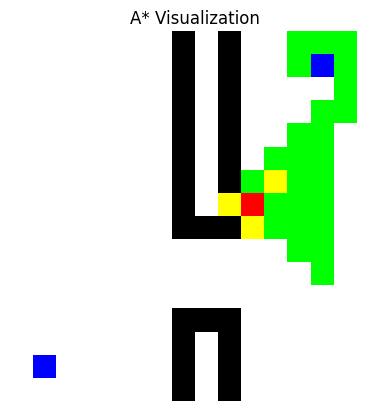

User:  Now, the agent has moved from [7, 11] to [7, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

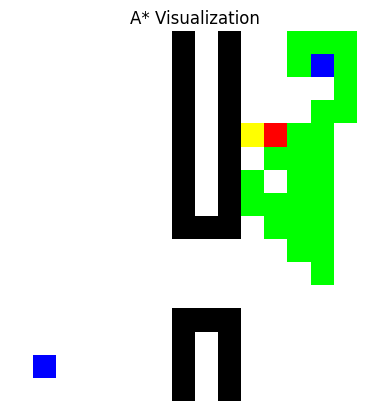

User:  Now, the agent has moved from [4, 12] to [4, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

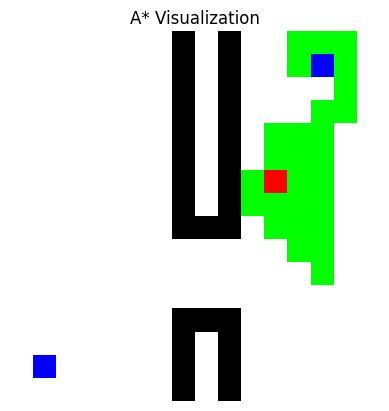

User:  Now, the agent has moved from [6, 10] to [6, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

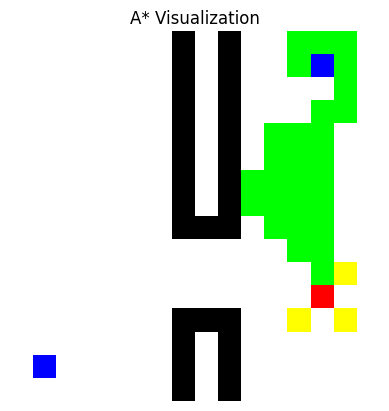

User:  Now, the agent has moved from [10, 13] to [11, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

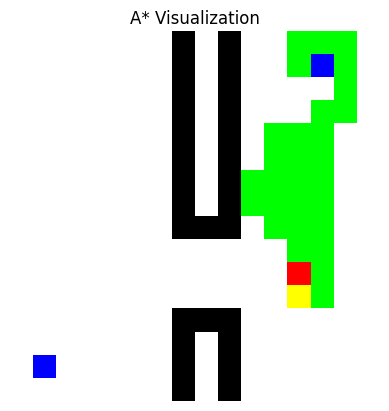

User:  Now, the agent has moved from [9, 12] to [10, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. C

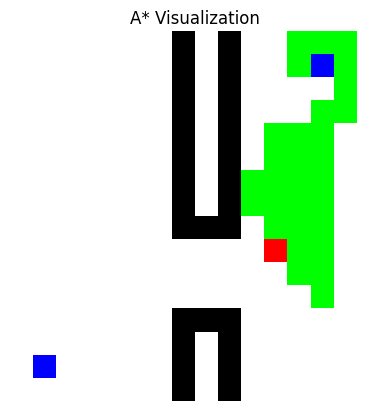

User:  Now, the agent has moved from [8, 11] to [9, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

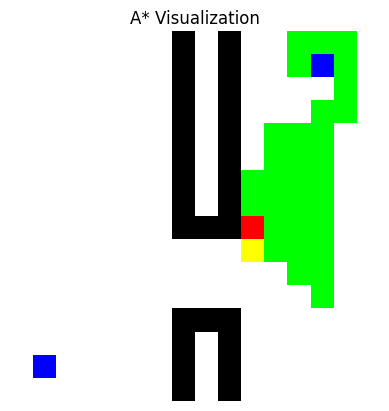

User:  Now, the agent has moved from [8, 11] to [8, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

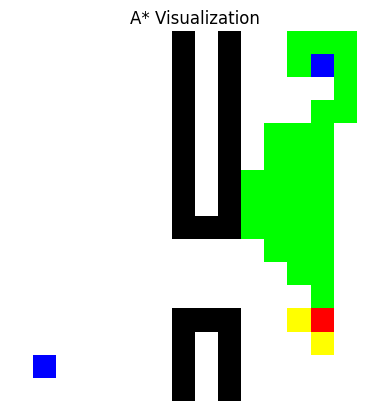

User:  Now, the agent has moved from [11, 13] to [12, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

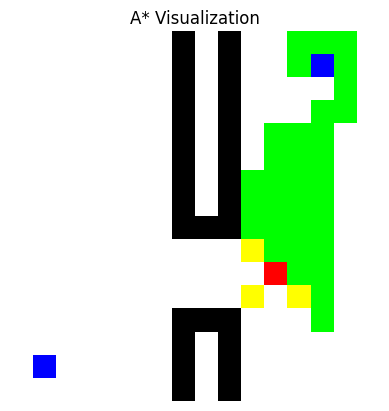

User:  Now, the agent has moved from [9, 11] to [10, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. C

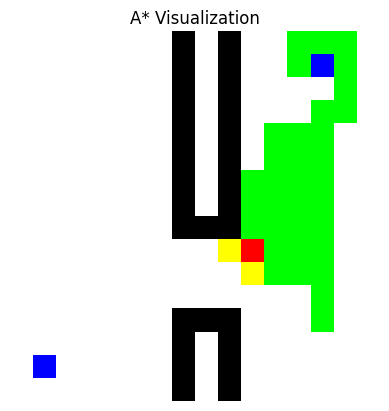

User:  Now, the agent has moved from [8, 10] to [9, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

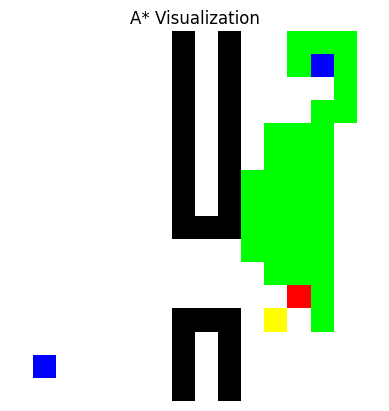

User:  Now, the agent has moved from [12, 13] to [11, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

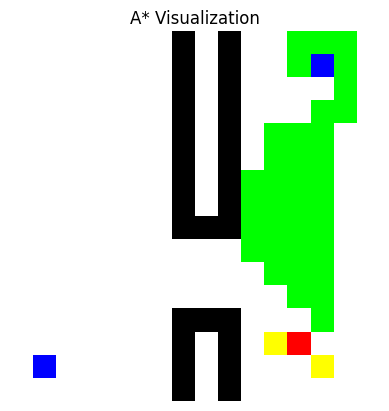

User:  Now, the agent has moved from [12, 13] to [13, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

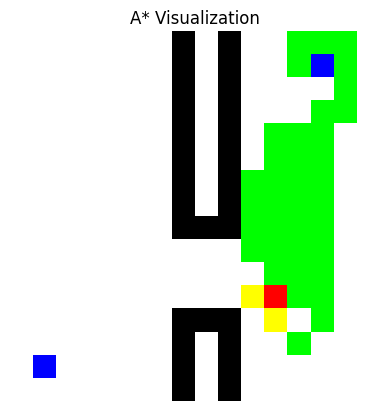

User:  Now, the agent has moved from [10, 11] to [11, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

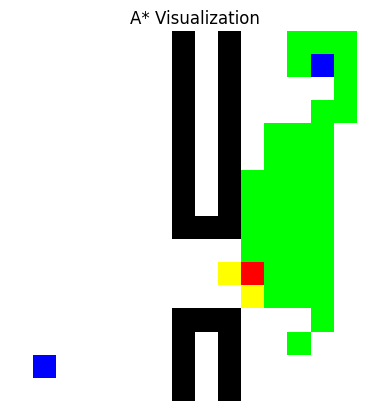

User:  Now, the agent has moved from [10, 11] to [10, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

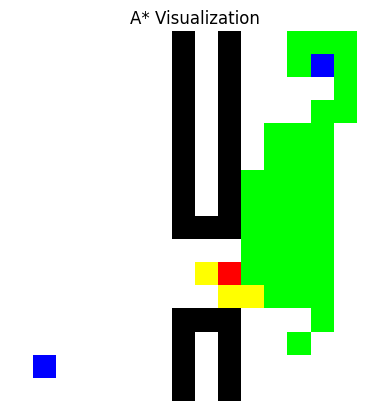

User:  Now, the agent has moved from [9, 10] to [10, 9] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

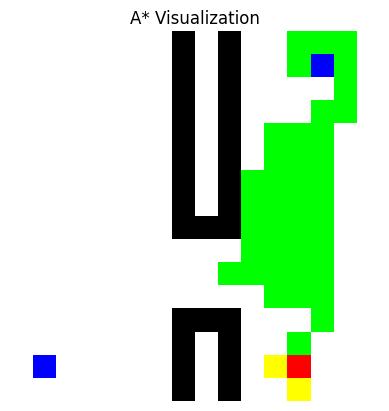

User:  Now, the agent has moved from [13, 12] to [14, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

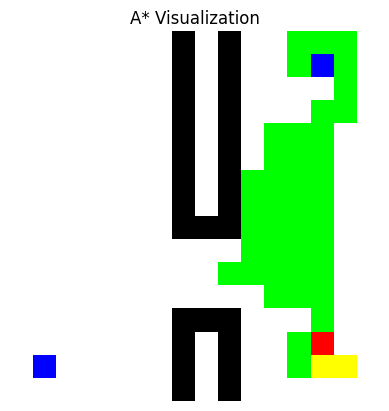

User:  Now, the agent has moved from [13, 12] to [13, 13] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

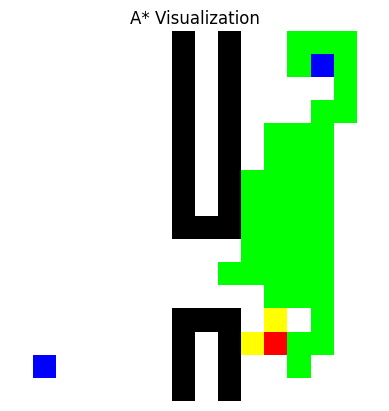

User:  Now, the agent has moved from [13, 12] to [13, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

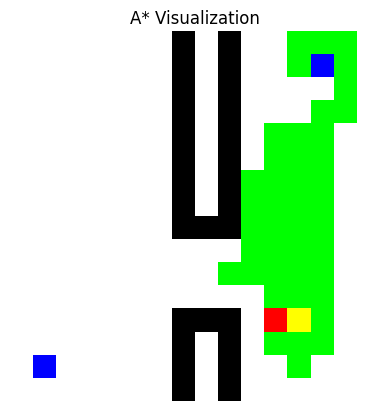

User:  Now, the agent has moved from [11, 11] to [12, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

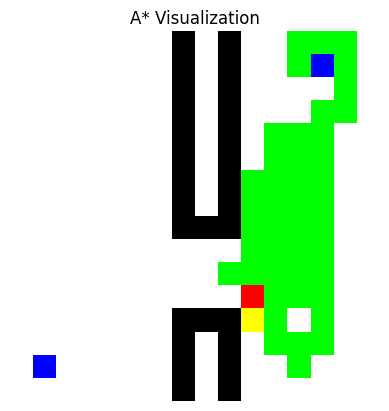

User:  Now, the agent has moved from [11, 11] to [11, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

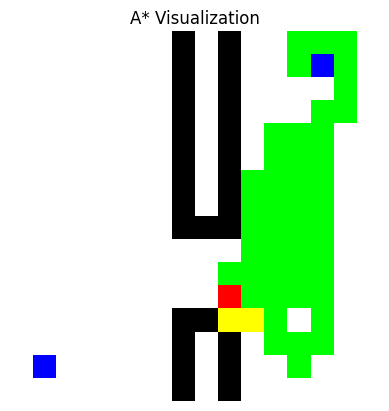

User:  Now, the agent has moved from [10, 9] to [11, 9] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

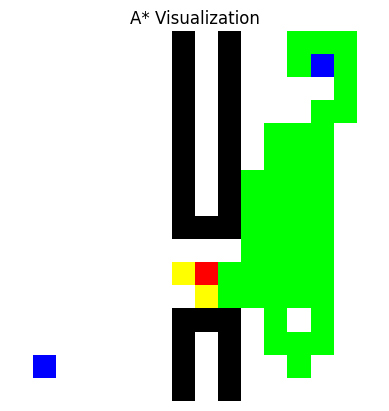

User:  Now, the agent has moved from [10, 9] to [10, 8] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

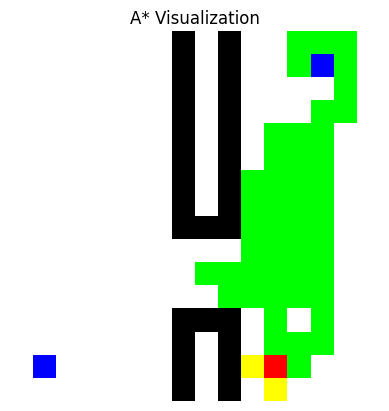

User:  Now, the agent has moved from [13, 11] to [14, 11] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

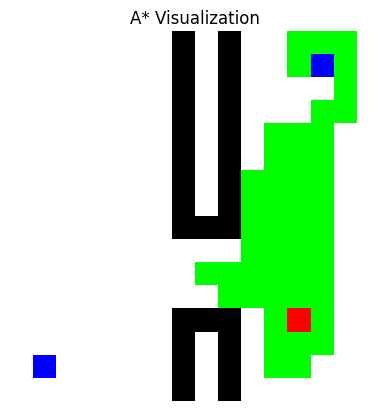

User:  Now, the agent has moved from [12, 11] to [12, 12] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

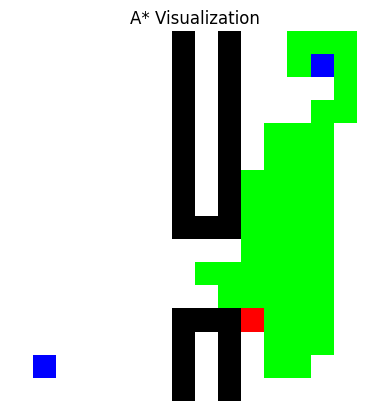

User:  Now, the agent has moved from [11, 10] to [12, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

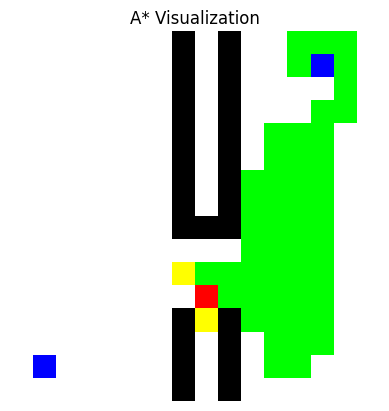

User:  Now, the agent has moved from [11, 9] to [11, 8] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

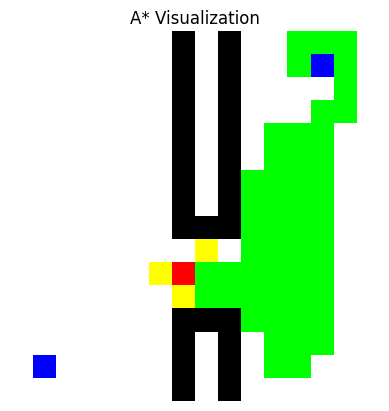

User:  Now, the agent has moved from [10, 8] to [10, 7] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

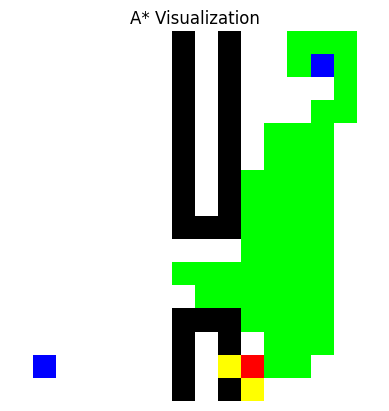

User:  Now, the agent has moved from [14, 11] to [14, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

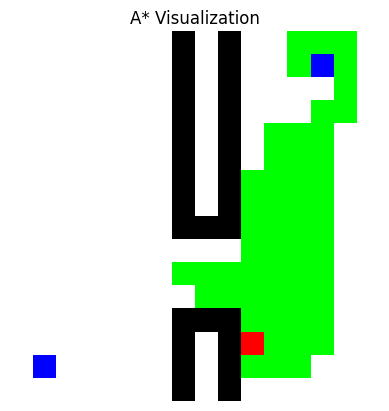

User:  Now, the agent has moved from [12, 10] to [13, 10] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. 

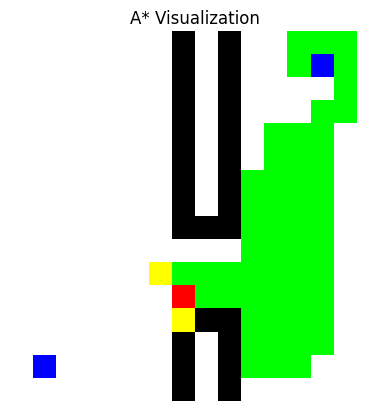

User:  Now, the agent has moved from [11, 8] to [11, 7] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

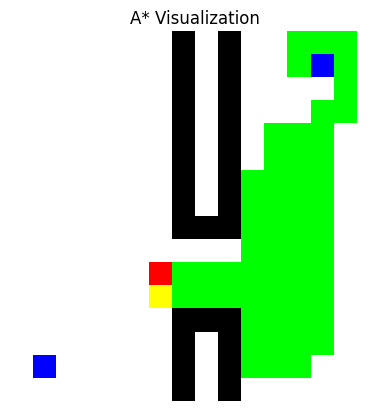

User:  Now, the agent has moved from [10, 7] to [10, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

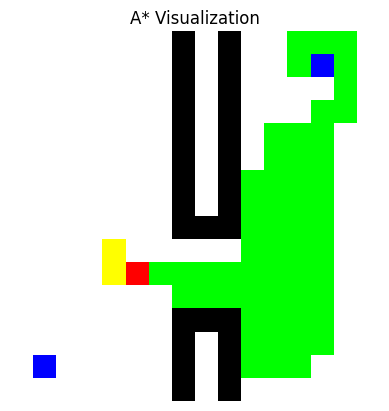

User:  Now, the agent has moved from [10, 6] to [10, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

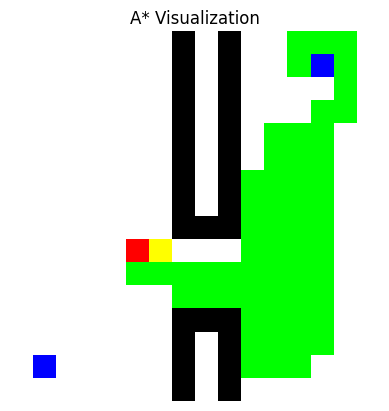

User:  Now, the agent has moved from [10, 6] to [9, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Con

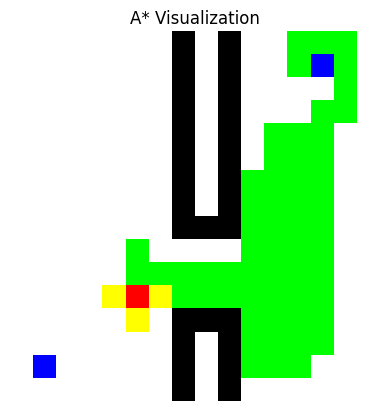

User:  Now, the agent has moved from [10, 5] to [11, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

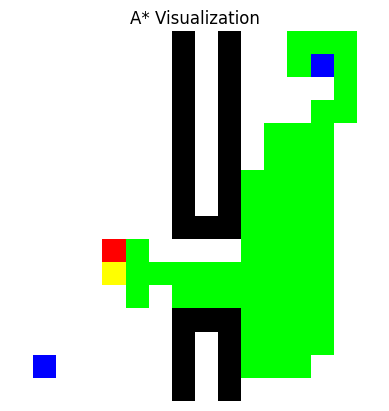

User:  Now, the agent has moved from [9, 5] to [9, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

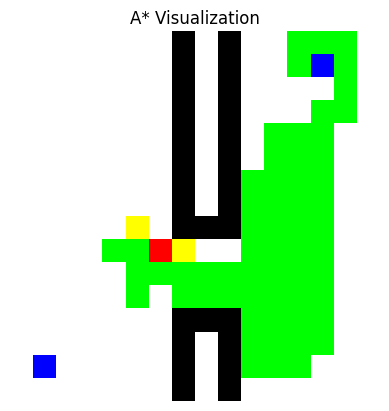

User:  Now, the agent has moved from [9, 5] to [9, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

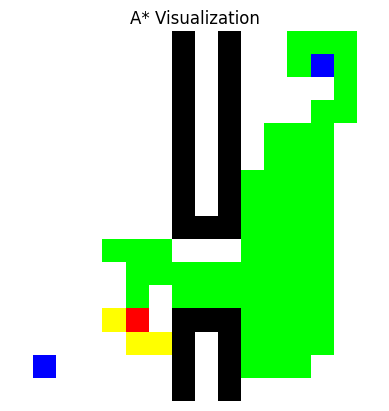

User:  Now, the agent has moved from [11, 5] to [12, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

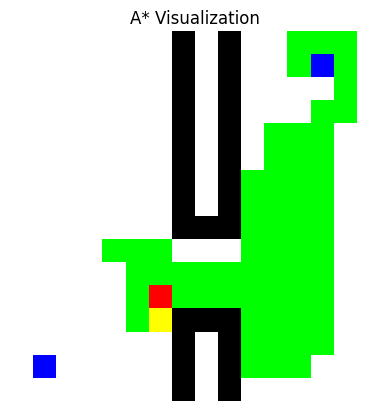

User:  Now, the agent has moved from [11, 5] to [11, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

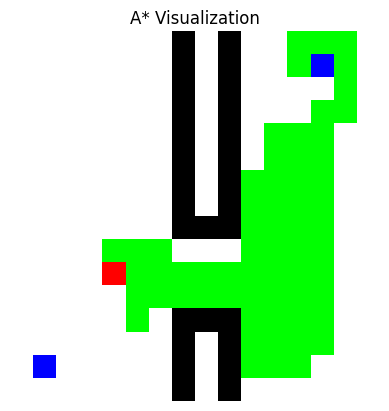

User:  Now, the agent has moved from [9, 4] to [10, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Con

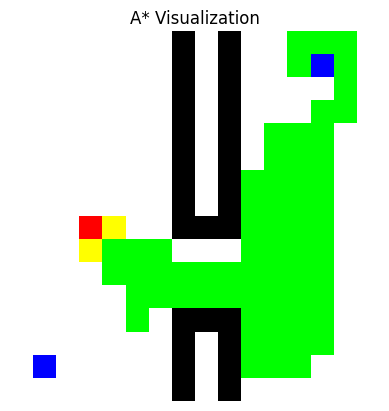

User:  Now, the agent has moved from [9, 4] to [8, 3] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

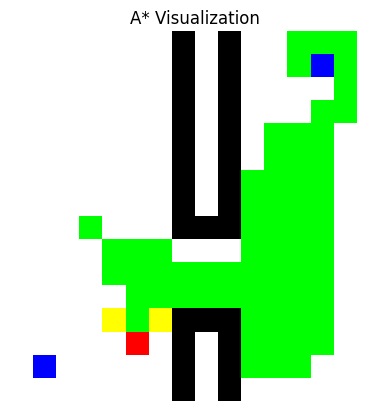

User:  Now, the agent has moved from [12, 5] to [13, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

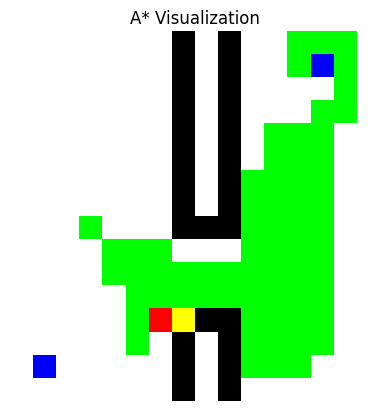

User:  Now, the agent has moved from [12, 5] to [12, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

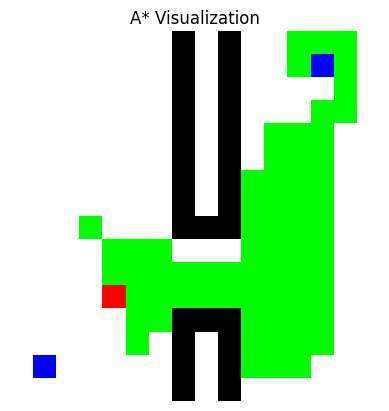

User:  Now, the agent has moved from [10, 4] to [11, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

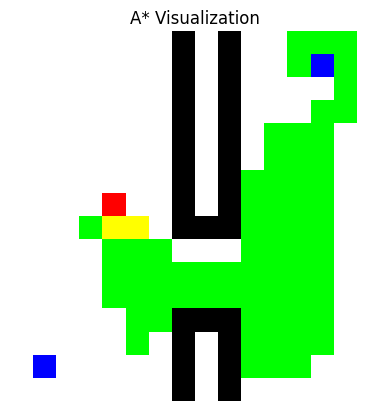

User:  Now, the agent has moved from [8, 3] to [7, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

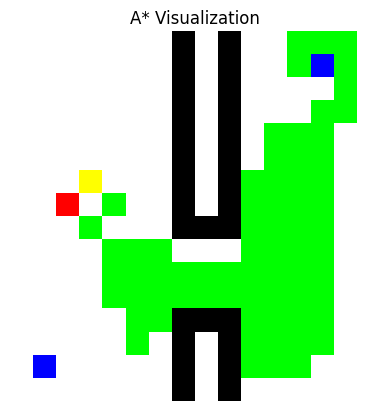

User:  Now, the agent has moved from [8, 3] to [7, 2] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

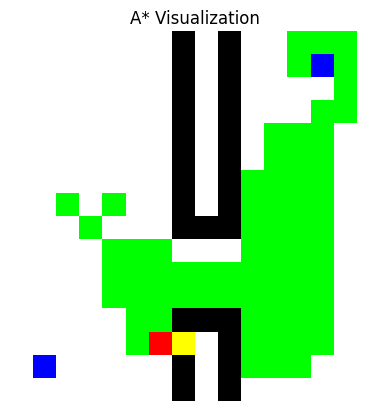

User:  Now, the agent has moved from [13, 5] to [13, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

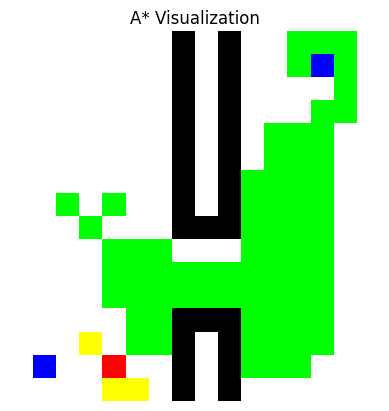

User:  Now, the agent has moved from [13, 5] to [14, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

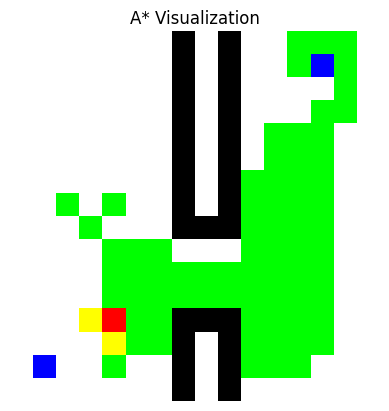

User:  Now, the agent has moved from [11, 4] to [12, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

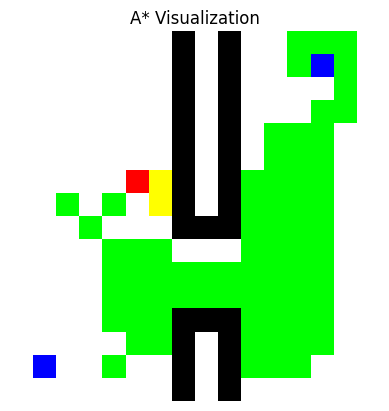

User:  Now, the agent has moved from [7, 4] to [6, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

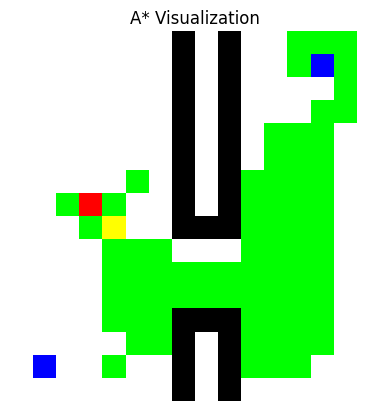

User:  Now, the agent has moved from [7, 2] to [7, 3] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

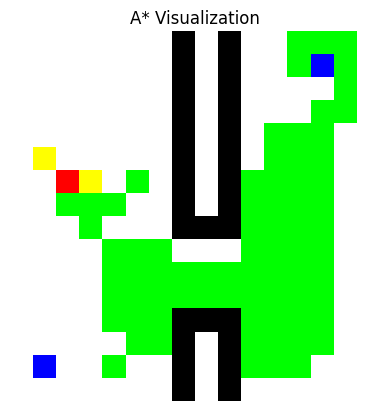

User:  Now, the agent has moved from [7, 3] to [6, 2] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

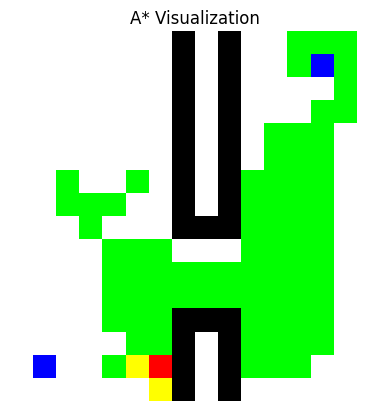

User:  Now, the agent has moved from [13, 6] to [14, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

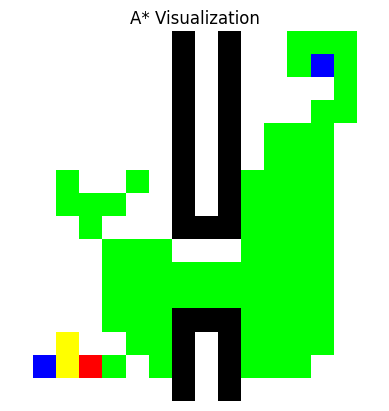

User:  Now, the agent has moved from [14, 4] to [14, 3] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

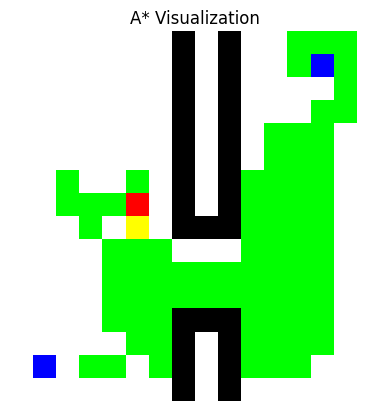

User:  Now, the agent has moved from [6, 5] to [7, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

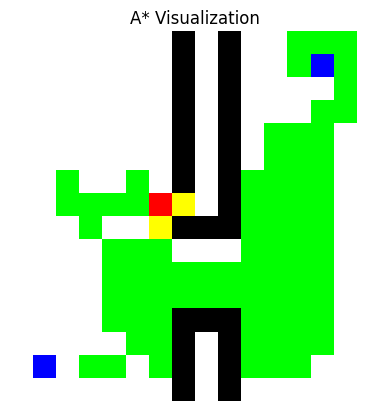

User:  Now, the agent has moved from [6, 5] to [7, 6] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

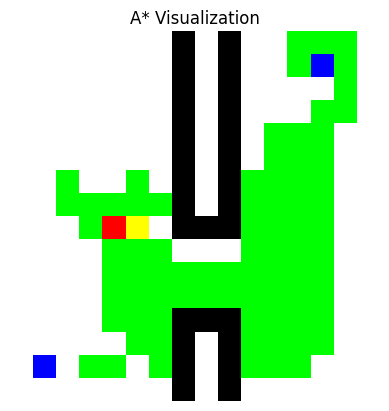

User:  Now, the agent has moved from [7, 3] to [8, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

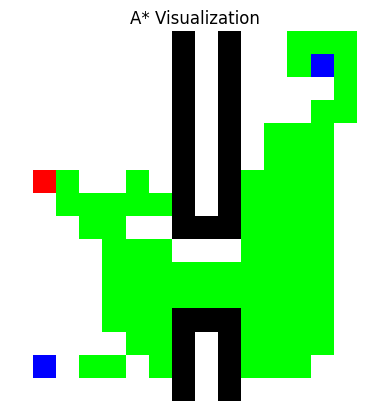

User:  Now, the agent has moved from [6, 2] to [6, 1] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

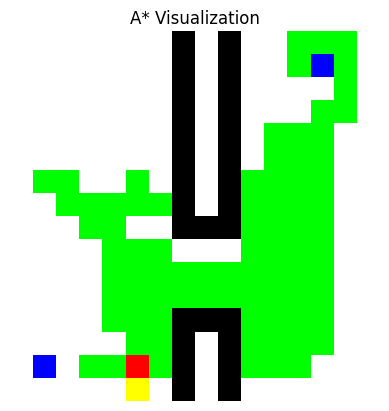

User:  Now, the agent has moved from [14, 6] to [14, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

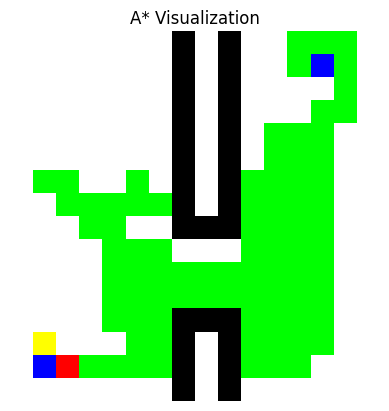

User:  Now, the agent has moved from [14, 3] to [14, 2] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

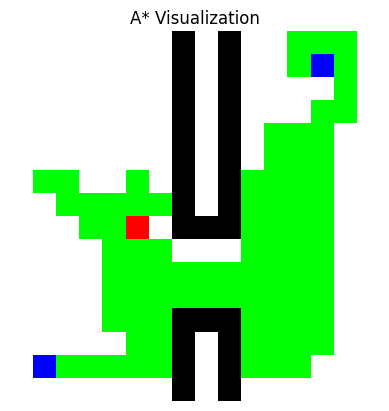

User:  Now, the agent has moved from [7, 5] to [8, 5] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

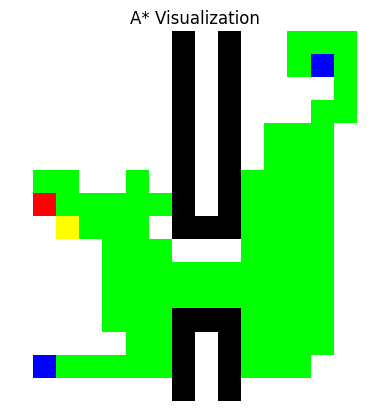

User:  Now, the agent has moved from [6, 1] to [7, 1] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Cons

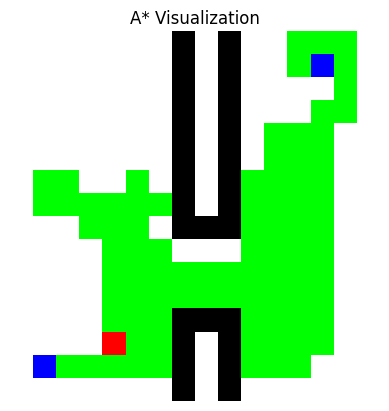

User:  Now, the agent has moved from [14, 5] to [13, 4] which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Co

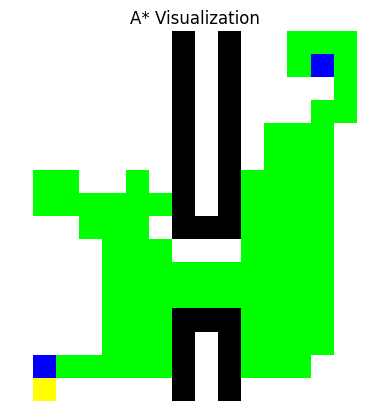

In [25]:
env.message_initialize()

while env.cur_node != env.target_node:
    messages = copy.deepcopy(env.ini_massages)

    # ask for subset of action space
    ask_opt_actions_inf = "Now, the agent has moved from " + str(env.pre_node) + " to " + str(env.cur_node) +" which is the current position. Considering the current node the agent stays at above, based on the information of target nodes obstacles, action space and our objective, please for only the next step return me a subset of action space in which there are several optimal actions satisfied with the factors below: 1. Take care the obstacle regions I told you. Please always be careful do not move to them. 2. Take care the action space which includes at most 8 actions allowed, especially for some cells adjacent to the obstacles. 3. All of the optimal actions should serve for the purpose 'achieve and reach the target node'. The agent must move in the correct direction while avoiding obstacles. Please prudentially deal with the causality relationship among obstacles and the correct direction and dinamically adjust and improve the solution. After selecting actions, please put the corresponding action numbers into a list and come out it. Considering the token limitation problem, please correctly and precisely remember the information above and do not return to much contexts for not only this but also the following prompt."
    print("User: ", ask_opt_actions_inf)
    messages.append({'role': 'user', 'content': ask_opt_actions_inf})

    # Sử dụng env.client thay vì client
    chat_for_task = env.client.chat.completions.create(
        model=env.model_name,
        messages=messages
    )
    reply_for_task = chat_for_task.choices[0].message.content
    print(f"Groq: {reply_for_task}")
    messages.append({'role': 'assistant', 'content': reply_for_task})

    ask_opt_actions_inf = "Please come out ONLY the action number list ITSELF again with the format 'opt_actions: [1, 2, 3]' and WITHOUT ANY OTHER CONTENTS WITH LIST FORMAT. This is exclusively for the convenience for extracting the action number list. So please do not output redundant information with the list format. "
    print("User: ", ask_opt_actions_inf)
    messages.append({'role': 'user', 'content': ask_opt_actions_inf})

    # Sử dụng env.client thay vì client
    chat_for_task = env.client.chat.completions.create(
        model=env.model_name,
        messages=messages
    )
    reply_for_task = chat_for_task.choices[0].message.content
    print(f"Groq: {reply_for_task}")
    messages.append({'role': 'assistant', 'content': reply_for_task})

    # extract optimal action list & save in search nodes memory
    opt_actions = env.extract_node(reply_for_task)

    if not opt_actions:
      print(f"⚠️ Step {env.step}: No optimal actions from {env.cur_node}, stopping.")
      break

    # select the optimal next step and save in optimal path memory
    env.opt_node_select(opt_actions)
    # update step

    env.step += 1
    env.visualize_step(opt_actions, env.cur_node)



In [26]:
my_love_path = copy.deepcopy(env.close_queue)
my_love_search = copy.deepcopy(env.open_queue)
steps = len(my_love_path)
open_steps = len(my_love_search)
total_step = steps + open_steps

In [28]:
the_map = copy.deepcopy(env.map)

In [29]:
for key in my_love_search:
  print(type(key), key)

<class 'int'> 1
<class 'int'> 3
<class 'int'> 4
<class 'int'> 8
<class 'int'> 26
<class 'int'> 31
<class 'int'> 35
<class 'int'> 47
<class 'int'> 48
<class 'int'> 54
<class 'int'> 59
<class 'int'> 81
<class 'int'> 89
<class 'int'> 94
<class 'int'> 95
<class 'int'> 96


In [30]:
# beta: avg_steering_angle -> maximum number of deviation angle

def generate_traj_map(map):

    map1 = copy.deepcopy(map)
    map2 = copy.deepcopy(map1)
    map = np.dstack((map, map1, map2)).astype(float)
    # int type causes the exception of decimal recognition.

    # Color the searched space, composing the searched grid map

    start_x = env.start_node[0]
    start_y = env.start_node[1]
    cur_x = start_x
    cur_y = start_y

    for key in my_love_search:
      #current_node = eval(key)
      current_node = my_love_search[key]
      x = current_node[0]
      y = current_node[1]
      # print(f"x: {x}")
      # print(f"y: {y}")
      map[x][y][0] = 0.0
      map[x][y][1] = 1.0
      map[x][y][2] = 0.0

    for key in my_love_path:
      x = my_love_path[key][0]
      y = my_love_path[key][1]
      map[x][y][0] = 0.0
      map[x][y][1] = 1.0
      map[x][y][2] = 0.0

    cur = goal
    # cur = env.cur_node
    parent = my_love_path[str(cur)]
    x_axis = [goal[0]]
    y_axis = [goal[1]]
    bas_dir_vector = np.array([0.0, 1.0])
    dis_vector = np.array(goal)-np.array(start)
    sum_angle = 0.0
    avg_angle = 0.0
    count = 0
    max_times = 0

    # trace back the path, calculating the length and avarage curvature

    while(parent != start):
      count += 1

      # update
      x_axis.append(parent[0])
      y_axis.append(parent[1])
      my_love_path.pop(str(cur))

      # caluculate angles

      dir_vector = np.array(cur) - np.array(parent)
      # print(f"bas_dir_vector: {bas_dir_vector}")

      # steering angle toward last vector
      angle = abs(np.arccos(np.clip(np.dot(dir_vector, bas_dir_vector)/(np.linalg.norm(dir_vector)*np.linalg.norm(bas_dir_vector)), -1.0, 1.0)))

      # steering angle toward displacement
      dis_angle = abs(np.arccos(np.clip(np.dot(dir_vector, dis_vector)/(np.linalg.norm(dir_vector)*np.linalg.norm(dis_vector)), -1.0, 1.0)))

      dis_angle = round(dis_angle, 3)
      angle = round(angle, 3)
      # print(f"angle: {angle}")

      sum_angle += angle
      avg_angle = round(sum_angle / float(count), 2)

      if dis_angle > math.pi / 2.0:
        max_times += 1

      cur = parent
      parent = my_love_path[str(cur)]
      bas_dir_vector = dir_vector
      # print(f"bas_dir_vector: {bas_dir_vector}\n")

    x_axis.append(env.start_node[0])
    y_axis.append(env.start_node[1])

    # return map, x_axis, y_axis, avg_angle
    return map, x_axis, y_axis, avg_angle, max_times

def color_path(map, x_axis, y_axis):

    color_0 = 1.0
    color_2 = 0.0
    delta_color = 1.0 / float(len(x_axis))
    for i in range(len(x_axis)):
      x = x_axis[i]
      y = y_axis[i]
      map[x][y][0] = color_0
      map[x][y][1] = 0.0
      map[x][y][2] = color_2

      color_0 -= delta_color
      color_2 += delta_color

    traj_map = (map * 255.0).astype(int)

    return traj_map, len(x_axis)

NameError: name 'key' is not defined

In [31]:
final_map, x_axis, y_axis, avg_angle, max_times = generate_traj_map(the_map)
final_map, path_len = color_path(final_map, x_axis, y_axis)

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

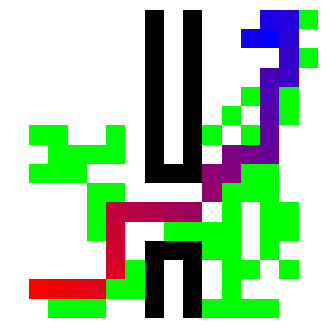

In [34]:
# Generate the interactive records
fig, axes = plt.subplots(1, 1, figsize=[12, 4])
axes.imshow(final_map)
axes.axis('off')

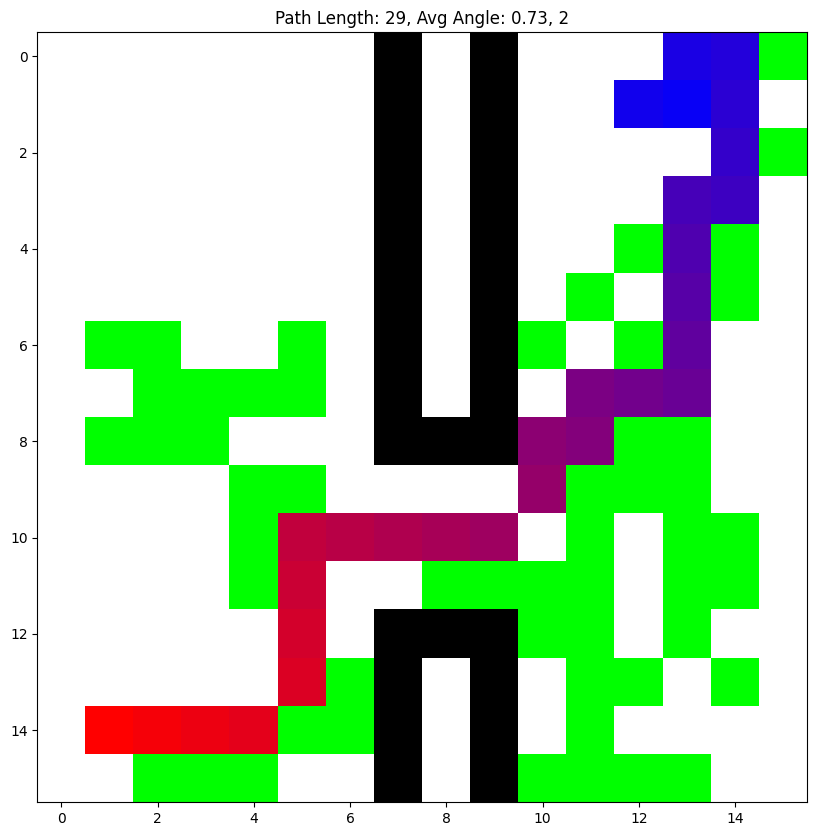

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(final_map)
plt.title(f"Path Length: {path_len}, Avg Angle: {avg_angle}, {max_times}")
plt.show()

In [35]:
def visualize_final_path(env):
    import matplotlib.pyplot as plt
    import numpy as np
    import copy
    import math

    my_love_path = copy.deepcopy(env.close_queue)
    the_map = copy.deepcopy(env.map)
    visited = copy.deepcopy(env.visited)

    map1 = copy.deepcopy(the_map)
    map2 = copy.deepcopy(map1)
    vis_map = np.dstack((the_map, map1, map2)).astype(float)

    # Tô chướng ngại vật màu đen
    for (i, j) in env.obs:
        vis_map[i, j] = [0, 0, 0]

    # Tô các node đã xét màu xanh lá cây
    for (i, j) in visited:
        vis_map[i, j] = [0, 1, 0]

    # Truy vết lại đường đi tối ưu
    cur = env.target_node
    parent = my_love_path[str(cur)]
    x_axis = [cur[0]]
    y_axis = [cur[1]]

    while parent != env.start_node:
        x_axis.append(parent[0])
        y_axis.append(parent[1])
        cur = parent
        parent = my_love_path[str(cur)]

    x_axis.append(env.start_node[0])
    y_axis.append(env.start_node[1])

    # Tô đường đi màu cam (gradient)
    color_0 = 1.0
    color_2 = 0.0
    delta_color = 1.0 / float(len(x_axis))
    for i in range(len(x_axis)):
        x = x_axis[i]
        y = y_axis[i]
        vis_map[x, y] = [color_0, 0.5, color_2]
        color_0 -= delta_color
        color_2 += delta_color

    # Tô điểm bắt đầu và kết thúc màu xanh dương
    si, sj = env.start_node
    gi, gj = env.target_node
    vis_map[si, sj] = [0, 0, 1]
    vis_map[gi, gj] = [0, 0, 1]

    # Hiển thị bản đồ
    vis_map = (vis_map * 255.0).astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.imshow(vis_map)
    plt.title("Final A* Path with Visited Nodes")
    plt.axis('off')
    plt.show()


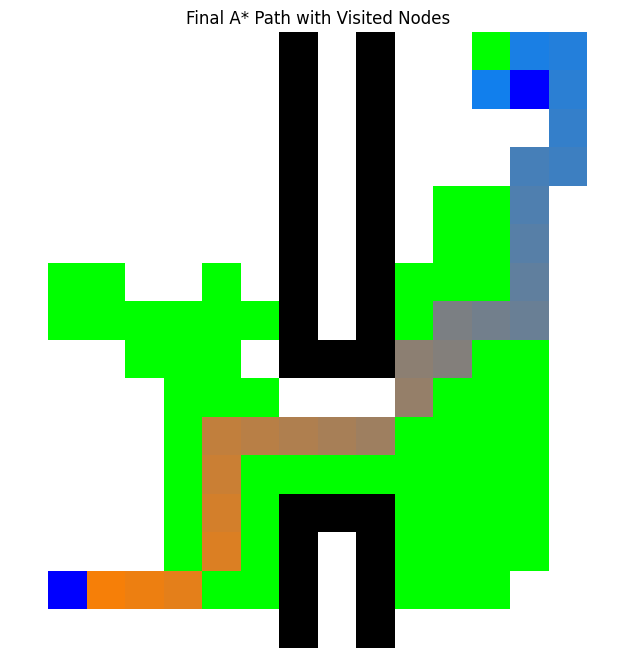

In [36]:
visualize_final_path(env)
